In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/gdrive')
tf.set_random_seed(777)  # reproducibility


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)
  
  
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [0]:
# Open, High, Low, Volume, Close
cwd = os.getcwd()
files = os.listdir(cwd)
print (files)
gdrive_path = os.path.join(cwd, "gdrive")
files_gdrive = os.listdir(gdrive_path)
print (files_gdrive)
mydrive_path = os.path.join(gdrive_path, "My Drive")
files_my = os.listdir(mydrive_path)
print (files_my)
# for my case
datadir = os.path.join(mydrive_path, "Colab Notebooks/data-02-stock_daily.csv")
xy = np.loadtxt(datadir, delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)
# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

['.config', 'sample_data', 'data', 'gdrive']
['My Drive', '.Trash']
['Colab Notebooks']
[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-0

In [0]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [0]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))



[step: 0] loss: 166.2140655517578
[step: 1] loss: 105.05766296386719
[step: 2] loss: 59.56279754638672
[step: 3] loss: 29.21882438659668
[step: 4] loss: 14.21298885345459
[step: 5] loss: 13.826706886291504
[step: 6] loss: 22.126541137695312
[step: 7] loss: 28.972869873046875
[step: 8] loss: 29.148345947265625
[step: 9] loss: 24.057565689086914
[step: 10] loss: 17.0750789642334
[step: 11] loss: 10.876198768615723
[step: 12] loss: 6.789780139923096
[step: 13] loss: 4.991913318634033
[step: 14] loss: 4.958414554595947
[step: 15] loss: 5.900998592376709
[step: 16] loss: 7.07088565826416
[step: 17] loss: 7.91677188873291
[step: 18] loss: 8.133447647094727
[step: 19] loss: 7.646057605743408
[step: 20] loss: 6.56451940536499
[step: 21] loss: 5.126851558685303
[step: 22] loss: 3.637399435043335
[step: 23] loss: 2.3999359607696533
[step: 24] loss: 1.6473321914672852
[step: 25] loss: 1.4777247905731201
[step: 26] loss: 1.8182681798934937
[step: 27] loss: 2.442272901535034
[step: 28] loss: 3.0503

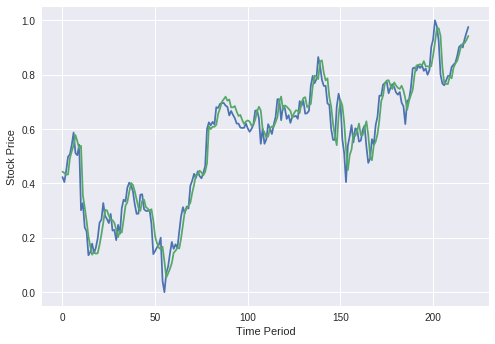

In [0]:
# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()